In [ ]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv2D
import matplotlib.pyplot as plt

In [3]:
loaded_pad = np.load("ml_data_pad_with_times.npz", allow_pickle=True)
ml_data_pad = loaded_pad["data"]
times_pad = loaded_pad["times"]

In [4]:
print(ml_data_pad.shape)
print(times_pad.shape)


(288, 4, 361, 240)
(288,)


### 1. Load the data

In [6]:
data_file = 'ml_data_pad_with_times.npz'
loaded = np.load(data_file, allow_pickle=True)
data = loaded['data']      # Shape: (288, 4, 361, 240)
times = loaded['times']    # Shape: (288,)

print("Original data shape:", data.shape)
print("Times shape:", times.shape)

# Convert data to "channels last" format.
# Current shape is (T, 4, 361, 240). We want (T, 361, 240, 4)
data = np.transpose(data, (0, 2, 3, 1))
print("Data shape (channels last):", data.shape)  # Expected: (288, 361, 240, 4)

Original data shape: (288, 4, 361, 240)
Times shape: (288,)
Data shape (channels last): (288, 361, 240, 4)


### 2. Create Time-Series Samples

In [7]:
# Use a sliding window of, e.g., 10 time steps as input and the 11th as the target.
window_size = 10
X = []
y = []
target_times = []

# For each sample, use images [i, i+1, ..., i+window_size-1] to predict image at i+window_size.
for i in range(len(data) - window_size):
    X.append(data[i : i + window_size])  # Shape: (window_size, 361, 240, 4)
    y.append(data[i + window_size])        # Shape: (361, 240, 4)
    target_times.append(times[i + window_size])
    
X = np.array(X)  # Final shape: (num_samples, window_size, 361, 240, 4)
y = np.array(y)  # Final shape: (num_samples, 361, 240, 4)
target_times = np.array(target_times)
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Number of samples:", X.shape[0])

X shape: (278, 10, 361, 240, 4)
y shape: (278, 361, 240, 4)
Number of samples: 278


### 3. Split Data into Training and Test Sets

In [8]:
num_samples = X.shape[0]
split_idx = int(0.8 * num_samples)

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
times_train, times_test = target_times[:split_idx], target_times[split_idx:]
print("Training samples:", X_train.shape)
print("Test samples:", X_test.shape)

Training samples: (222, 10, 361, 240, 4)
Test samples: (56, 10, 361, 240, 4)


### 4. Build ConvLSTM2D Model

In [9]:
# The model will accept an input of shape (window_size, 361, 240, 4)
# and output an image of shape (361, 240, 4).
model = Sequential()

# First ConvLSTM2D layer: return sequences for further processing.
model.add(ConvLSTM2D(filters=32,
                     kernel_size=(3, 3),
                     activation='relu',
                     return_sequences=True,
                     padding='same',
                     input_shape=(window_size, 361, 240, 4)))
model.add(BatchNormalization())

# Second ConvLSTM2D layer: return a single output (the last output in the sequence).
model.add(ConvLSTM2D(filters=32,
                     kernel_size=(3, 3),
                     activation='relu',
                     return_sequences=False,
                     padding='same'))
model.add(BatchNormalization())

# A final Conv2D layer to output 4 channels with the same spatial dimensions.
# Use 'sigmoid' if your pixel values are normalized between 0 and 1.
model.add(Conv2D(filters=4, kernel_size=(3, 3), activation='linear', padding='same'))

model.compile(optimizer='adam', loss='mse')
model.summary()

2025-02-02 15:01:24.708184: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-02-02 15:01:24.708238: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-02-02 15:01:24.708248: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-02-02 15:01:24.708538: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-02 15:01:24.708567: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/jpweideman/Radar-Consulting/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When usi

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 10, 361, 240,   │        41,600 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10, 361, 240,   │           128 │
│ (BatchNormalization)            │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 361, 240, 32)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 361, 240, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 361, 240, 4)    │         1,156 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,868 (456.52 KB)

 Trainable params: 116,740 (456.02 KB)

 Non-trainable params: 128 (512.00 B)

### 5. Train the Model


In [11]:
with tf.device('/GPU:0'):
    history = model.fit(X_train, y_train, 
                    epochs=5, 
                    batch_size=2, 
                    validation_data=(X_test, y_test))

Epoch 1/5


2025-02-02 15:01:50.130570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


111/111 ━━━━━━━━━━━━━━━━━━━━ 441s 4s/step - loss: 3999.0129 - val_loss: 3565.7747
Epoch 2/5
111/111 ━━━━━━━━━━━━━━━━━━━━ 373s 3s/step - loss: 3176.4412 - val_loss: 2394.6824
Epoch 3/5
111/111 ━━━━━━━━━━━━━━━━━━━━ 367s 3s/step - loss: 1676.8676 - val_loss: 1376.2167
Epoch 4/5
111/111 ━━━━━━━━━━━━━━━━━━━━ 374s 3s/step - loss: 597.6835 - val_loss: 280.5075
Epoch 5/5
111/111 ━━━━━━━━━━━━━━━━━━━━ 374s 3s/step - loss: 267.2477 - val_loss: 249.2000


In [ ]:
#save the model
#model.save("checkpoints/model1.h5")
model.save("checkpoints/model1.keras")


In [ ]:
# #Load the model
# model = tf.keras.models.load_model('checkpoints/model1.keras')

/Users/jpweideman/Radar-Consulting/.venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [35]:
# #TO CONTINUE TRAINING:

# from tensorflow.keras.models import load_model
# # Load your saved model (adjust the file path as needed)
# model = load_model('checkpoints/model1.keras')

# # Now, continue training using model.fit with your data
# with tf.device('/GPU:0'):
#     history = model.fit(X_train, y_train,
#                     epochs=2,         # number of additional epochs
#                     batch_size=2,
#                     validation_data=(X_test, y_test))

/Users/jpweideman/Radar-Consulting/.venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/2
111/111 ━━━━━━━━━━━━━━━━━━━━ 373s 3s/step - loss: 244.7213 - val_loss: 252.4220
Epoch 2/2
111/111 ━━━━━━━━━━━━━━━━━━━━ 387s 3s/step - loss: 241.5596 - val_loss: 416.0592



### 6. Evaluation


In [55]:
test_loss = model.evaluate(X_test, y_test)
print("Test loss:", test_loss)

2/2 ━━━━━━━━━━━━━━━━━━━━ 22s 8s/step - loss: 250.1709
Test loss: 249.199951171875


In [47]:
# Predictions
y_pred = model.predict(X_test)


1/2 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/stepWARNING:tensorflow:6 out of the last 10 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x4a723ac00> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 29s 8s/step


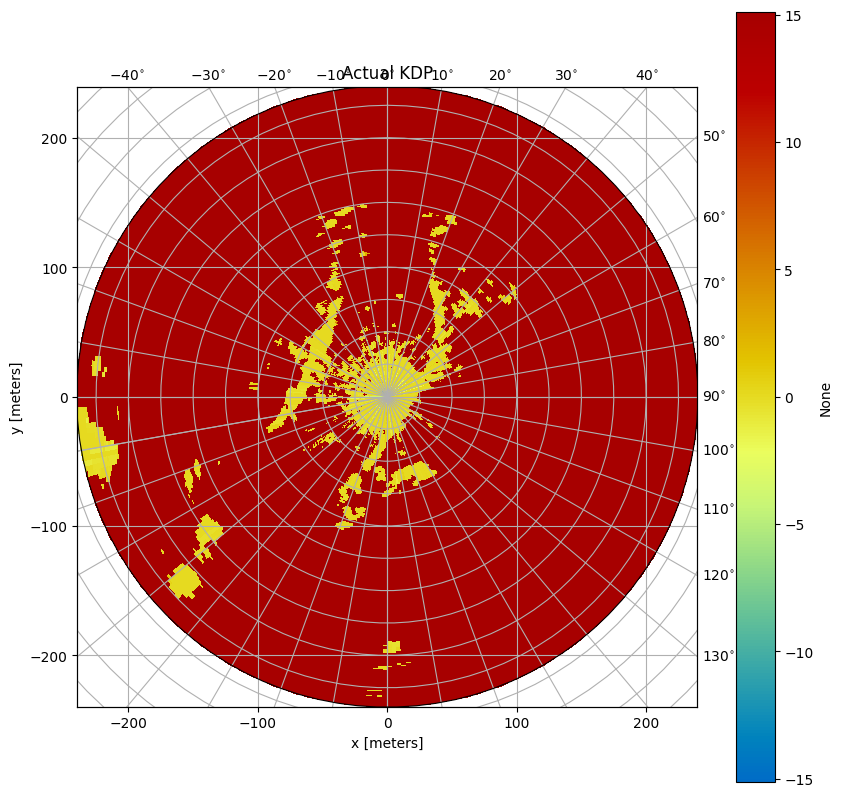

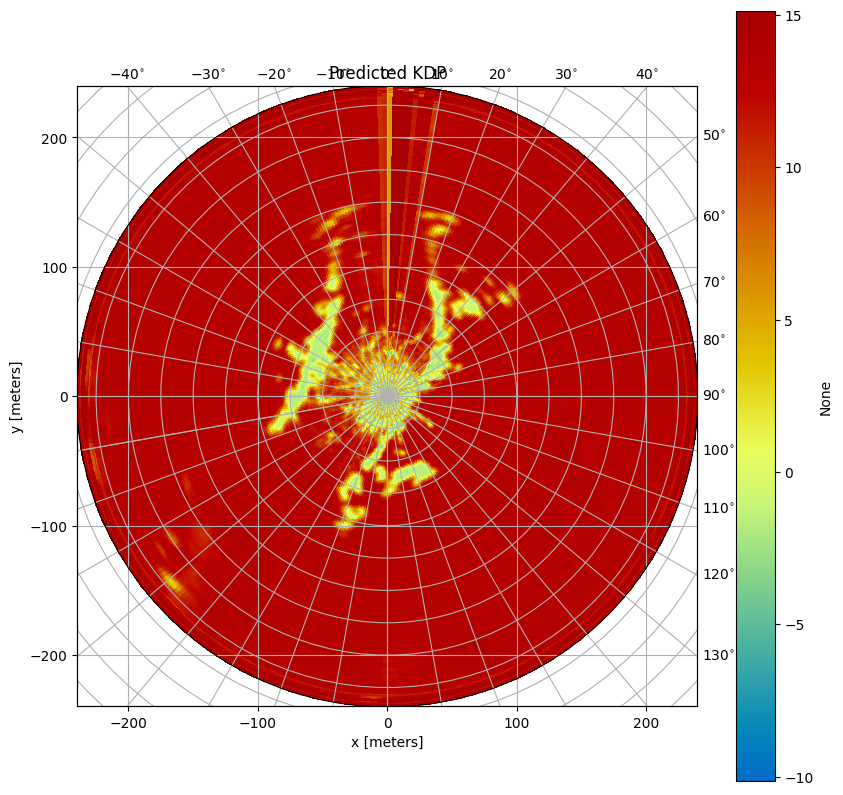

In [65]:
import matplotlib.pyplot as plt
import wradlib as wrl
import numpy as np

# Choose a sample index to visualize:
sample_idx = 1

# Extract the KDP channel (channel 0 is KDP) from the actual and predicted outputs.
actual_kdp = y_test[sample_idx][:, :, 0]
predicted_kdp = y_pred[sample_idx][:, :, 0]

# Determine consistent color limits for both plots
vmin = np.min(actual_kdp)
vmax = np.max(actual_kdp)

# Create xarray DataArrays and Georeference Them
da_actual = wrl.georef.create_xarray_dataarray(actual_kdp)
da_actual = da_actual.wrl.georef.georeference()

da_predicted = wrl.georef.create_xarray_dataarray(predicted_kdp)
da_predicted = da_predicted.wrl.georef.georeference()

# Plot the Actual Output
fig_actual = plt.figure(figsize=(10, 10))
im_actual = da_actual.wrl.vis.plot(fig=fig_actual, crs="cg")
plt.title("Actual KDP")
plt.show()

# Plot the Predicted Output
fig_pred = plt.figure(figsize=(10, 10))
im_pred = da_predicted.wrl.vis.plot(fig=fig_pred, crs="cg", vmin=vmin, vmax=vmax)
plt.title("Predicted KDP")
plt.show()

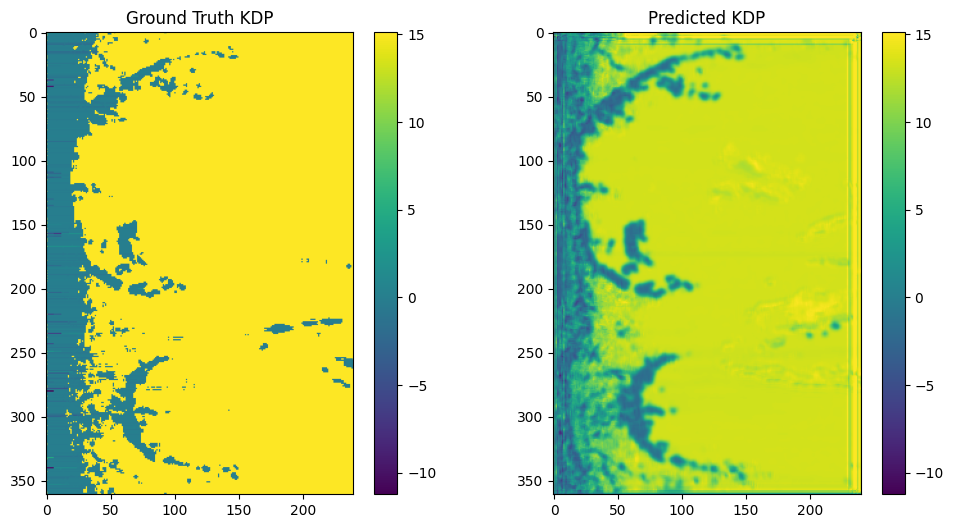

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure both plots use the same color scale
vmin = np.min(y_test[sample_idx, :, :, 0])
vmax = np.max(y_test[sample_idx, :, :, 0])

# Visualize one prediction: for example, sample 0, display channel 0 (KDP).
sample_idx = 0
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(y_test[sample_idx, :, :, 0], cmap='viridis', vmin=vmin, vmax=vmax)
plt.title("Ground Truth KDP")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(y_pred[sample_idx, :, :, 0], cmap='viridis', vmin=vmin, vmax=vmax)
plt.title("Predicted KDP")
plt.colorbar()

plt.show()